In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
# This is just to make plots appear in the notebook
%matplotlib inline

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('cleaned.csv', index_col=None)
df.head(10)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock
5,154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632,Rock
6,155,0.981657,0.142249,0.912122,0.967294,0.363510,0.087527,91.912,0.034325,Rock
7,169,0.989141,0.225978,0.722835,0.263076,0.092371,0.053406,94.322,0.028347,Rock
8,170,0.886660,0.298518,0.744333,0.920950,0.139587,0.088781,97.880,0.073548,Rock
9,171,0.698278,0.285816,0.213494,0.955691,0.087036,0.064094,125.645,0.150599,Rock


### Pairwise relationships between continuous variables

We typically want to avoid using variables that have strong correlations with each other, hence avoiding feature redundancy to keep the model simple and improve interpretability (with many features, we run the risk of overfitting).
When our datasets are very large, using fewer features can drastically speed up our computation time.

In [3]:
# Create a correlation matrix
corr_matrix = df.corr()
corr_matrix.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


### Normalizing the feature data

Since we didn’t find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called principal component analysis (PCA).

Normalization and Standardization
https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/


In [4]:
#from sklearn import preprocessing

# Separating out the features 
x_features = df.drop(["genre_top","track_id"], axis=1)

# # Separating out the target
y_target = df["genre_top"]

#standardization
std_scaled = preprocessing.StandardScaler().fit_transform(x_features)
#minmax_scale = preprocessing.MinMaxScaler().fit_transform(x_features)

### Principal component analysis on our scaled data

In [5]:
#from sklearn.decomposition import PCA
pca = PCA()
pca.fit(std_scaled)

PCA()

While applying PCA you can mention how many principal components you want to keep...#pca=PCA(n_components=3)

The explained variance tells you how much information (variance) can be attributed to each of the principal components.

In [6]:
variances = pca.explained_variance_ratio_
variances

array([0.24297674, 0.18044316, 0.13650309, 0.12994089, 0.11056248,
       0.08302245, 0.06923783, 0.04731336])

<BarContainer object of 8 artists>

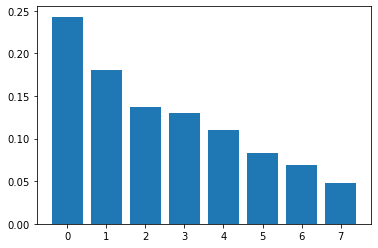

In [7]:
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),variances)

### Further visualization of PCA

Cumulative explained variance plot is used to determine how many features are required.We determine the appropriate number of components, so that can perform PCA with that many components, ideally reducing the dimensionality of our data.

In [8]:
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(variances)
cumulative_variance

array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

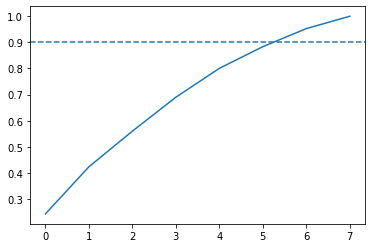

In [9]:
fig, ax = plt.subplots()
ax.plot(range(8), cumulative_variance)
ax.axhline(y=0.9, linestyle='--')

In above plot 0.9 indicates Scikit-learn choose the minimum number of principal components such that 90% of the variance is retained.

In [10]:
n_components = 6

# Perform PCA with the chosen number of components & Apply the mapping (transform)
pca = PCA(n_components, random_state=1)
pca.fit(std_scaled)
pca_projection = pca.transform(std_scaled)
pca_projection

array([[ 1.59666656,  1.0500117 , -0.01778555,  0.73142514, -0.36832686,
        -0.71505324],
       [ 1.58153526,  1.07661327,  1.04346038,  0.16929959, -1.81917099,
         1.3884574 ],
       [ 2.01545627,  1.4085176 ,  0.24506524, -1.53545814,  0.62769959,
        -0.45716338],
       ...,
       [ 1.66908628,  1.84010121,  2.38294303, -2.12871589,  1.23664547,
        -0.63277253],
       [ 1.17001951,  2.03158181,  0.08689922,  0.88396123, -1.45765649,
        -0.03590123],
       [ 2.36368976,  1.15900708,  0.4473735 , -1.35198128, -0.03592518,
         0.82678557]])

In [11]:
pca_projection.shape

(4802, 6)

### Train a decision tree to classify genre


In [12]:
# Split our data
X_train, X_test, y_train, y_test = train_test_split(pca_projection, y_target,random_state=42)

# Train our decision tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

#Predicting the Test set results
y_pred = tree.predict(X_test)

Making the Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[146  79]
 [ 91 885]]


0.858451290591174

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Hip-Hop       0.62      0.65      0.63       225
        Rock       0.92      0.91      0.91       976

    accuracy                           0.86      1201
   macro avg       0.77      0.78      0.77      1201
weighted avg       0.86      0.86      0.86      1201




### Compare our decision tree model to a logistic regression

In [15]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 42)
classifier.fit(X_train, y_train)
y_pred_logreg = classifier.predict(X_test)

Making the Confusion Matrix

In [16]:
cm = confusion_matrix(y_test, y_pred_logreg)
print(cm)
accuracy_score(y_test, y_pred_logreg)

[[121 104]
 [ 34 942]]


0.8850957535387177

In [17]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

     Hip-Hop       0.78      0.54      0.64       225
        Rock       0.90      0.97      0.93       976

    accuracy                           0.89      1201
   macro avg       0.84      0.75      0.78      1201
weighted avg       0.88      0.89      0.88      1201



Both our models do similarly well, boasting an average precision of 86% each. However, looking at our classification report, we can see that rock song are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs.
Why might this be the case?
Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model’s ability to distinguish between classes.

In [18]:
y_target.value_counts()

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

To account for this,Balance our data for greater performance.

### Balance our data for greater performance

In [19]:
hop = df.loc[df["genre_top"] == "Hip-Hop"]
rock = df.loc[df["genre_top"] == "Rock"]

In [20]:
print(len(hop))
print(len(rock))

910
3892


In [21]:
balanced_data_set = pd.concat([rock.sample(n=910,random_state=10), hop.sample(n=910)], axis=0)
balanced_data_set.genre_top.value_counts()

Hip-Hop    910
Rock       910
Name: genre_top, dtype: int64

### Does balancing our dataset improve model bias?

In [22]:
x_features_bal = balanced_data_set.drop(['genre_top', 'track_id'], axis=1) 
y_target_bal = balanced_data_set['genre_top']
std_scaled_bal = preprocessing.StandardScaler().fit_transform(x_features_bal)

pca_bal = PCA(n_components, random_state=1)
pca_bal.fit(std_scaled_bal)
pca_projection_bal = pca.transform(std_scaled_bal)

In [23]:
pca_projection_bal.shape

(1820, 6)

In [24]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(pca_projection_bal, y_target_bal,random_state=0)

# Train our decision tree
tree_bal = DecisionTreeClassifier(random_state=42)
tree_bal.fit(X_train_bal, y_train_bal)

#Predicting the Test set results
y_pred_bal = tree_bal.predict(X_test_bal)

In [25]:
print(X_train_bal.shape)
print(X_test_bal.shape)
print(y_train_bal.shape)
print(y_test_bal.shape)

(1365, 6)
(455, 6)
(1365,)
(455,)


In [26]:
#decision tree
cm_bal = confusion_matrix(y_test_bal, y_pred_bal)
print(cm_bal)
accuracy_score(y_test_bal, y_pred_bal)

[[181  48]
 [ 47 179]]


0.7912087912087912

In [27]:
classifier_bal = LogisticRegression(random_state = 42)
classifier_bal.fit(X_train_bal, y_train_bal)
y_pred_logreg_bal = classifier_bal.predict(X_test_bal)

In [28]:
cm_bal = confusion_matrix(y_test_bal, y_pred_logreg_bal)
print(cm_bal)
accuracy_score(y_test_bal, y_pred_logreg_bal)

[[187  42]
 [ 35 191]]


0.8307692307692308

In [29]:
print("Decision Tree: \n", classification_report(y_test_bal, y_pred_bal))
print("Logistic Regression: \n", classification_report(y_test_bal,y_pred_logreg_bal ))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.79      0.79       229
        Rock       0.79      0.79      0.79       226

    accuracy                           0.79       455
   macro avg       0.79      0.79      0.79       455
weighted avg       0.79      0.79      0.79       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.82      0.83       229
        Rock       0.82      0.85      0.83       226

    accuracy                           0.83       455
   macro avg       0.83      0.83      0.83       455
weighted avg       0.83      0.83      0.83       455



### Using cross-validation to evaluate our models

In [30]:
from sklearn.model_selection import KFold, cross_val_score

In [31]:
# Set up our K-fold cross-validation
kf = KFold(n_splits=30)

In [32]:
tree = DecisionTreeClassifier(random_state=42)
logreg = LogisticRegression(random_state=42)

In [33]:
# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, y_target, cv=kf)
log_reg_score = cross_val_score(logreg, pca_projection,y_target, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(log_reg_score))

Decision Tree: 0.8600375258799172 Logistic Regression: 0.8727355072463768


In [34]:
# Saving model to disk
Pkl_Filename = "model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(classifier_bal, file)

In [35]:
# Saving model to disk
#pickle.dump(classifier_bal, open('model.pkl','wb'))
# Loading model to compare the results
#model = pickle.load(open('model.pkl','rb'))